In [1]:
import argparse
import roypy
import time
import queue
from sample_camera_info import print_camera_info
from roypy_sample_utils import CameraOpener, add_camera_opener_options
#from roypy_platform_utils import PlatformHelper

import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import math
from matplotlib.path import Path

import socket_sender
import _RANSAC
import _Find_quad
import _HMD_Light_function
import _Tranform_Data
import _feet_detection
import _Record_img
import _Feet_detection_by_center


try:
    import roypycy
except ImportError:
    print("Pico Flexx backend requirements (roypycy) not installed properly")
    raise

In [2]:
def depth_range_mask(depthImg, low, height):
    highter_region = depthImg > low
    lower_region = depthImg < height
    depth_mask = np.logical_and(highter_region, lower_region)
    
    depth_mask_ = depth_mask.astype(np.uint8)*255
    
    kernel_size = 5 #7
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_size, kernel_size))
    #膨胀之后再腐蚀，在用来关闭前景对象里的小洞或小黑点
    #开运算用于移除由图像噪音形成的斑点
    opened = cv2.morphologyEx(depth_mask_, cv2.MORPH_OPEN, kernel)
    depth_mask_ = cv2.morphologyEx(opened,cv2.MORPH_CLOSE,kernel)
    
     #find Contours with largest area 
    (_, cnts, _) = cv2.findContours(depth_mask_, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) > 0:
        cnt_ = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        
        peri = cv2.arcLength(cnt_, True)
        approx = cv2.approxPolyDP(cnt_, 0.03* peri, True)
        hull = cv2.convexHull(approx)
        
        #mask of max contour area
        max_area_mask = np.zeros(depthImg.shape, dtype='uint8')  #依Contours圖形建立mask
        cv2.drawContours(max_area_mask, [hull], -1, 255, -1) #255        →白色, -1→塗滿
        
        #mask the depth mask with max_area_mask
        mask = cv2.add(depth_mask_, np.zeros(np.shape(depthImg), dtype='uint8'), mask=max_area_mask)
        
        depth_img_with_mask = cv2.add(depthImg, np.zeros(np.shape(depthImg), dtype=np.float32), mask=mask)
    
    else:
        depth_img_with_mask = cv2.add(depthImg, np.zeros(np.shape(depthImg), dtype=np.float32), mask=depth_mask_)
        mask = depth_mask_
    
    
    
    return mask, depth_img_with_mask

In [3]:
class MyListener(roypy.IDepthDataListener):
    def __init__(self, xqueue, yqueue, zqueue, grayValuequeue):
        super(MyListener, self).__init__()
        self.xqueue = xqueue
        self.yqueue = yqueue
        self.zqueue = zqueue
        self.grayValuequeue = grayValuequeue
        self.Listening = True

    def onNewData(self, data):   
        if(self.Listening):
            t_time = time.time()
            
            xvalues = []
            yvalues = []
            zvalues = []
            grayvalues = []
            
            values = roypycy.get_backend_data(data)

            xvalues = values.x
            yvalues = values.y
            zvalues = values.z
            grayvalues = values.grayValue

            xarray = np.asarray(xvalues)
            yarray = np.asarray(yvalues)
            zarray = np.asarray(zvalues)
            
            
            q_x = xarray.reshape (-1, data.width)        
            self.xqueue.put(q_x)
            q_y = yarray.reshape (-1, data.width)        
            self.yqueue.put(q_y)
            q_z = zarray.reshape (-1, data.width)        
            self.zqueue.put(q_z)
            
            q_grayvalues = grayvalues.reshape (-1, data.width)        
            self.grayValuequeue.put(q_grayvalues)
            
            #print('store time:', (time.time()-t_time))

    def paint (self, data, name):
        """Called in the main thread, with data containing one of the items that was added to the
        queue in onNewData.
        """
        cv2.namedWindow(name, cv2.WINDOW_NORMAL)
        cv2.imshow(name, data)
        cv2.waitKey(1)



In [4]:

def main ():
    parser = argparse.ArgumentParser (usage = __doc__)
    add_camera_opener_options (parser)
    parser.add_argument ("--seconds", type=int, default=15, help="duration to capture data")
    parser.add_argument ("--SendData", type=bool, default=False, help="SendData")
    parser.add_argument ("--Project_Type", type=int, default=0, help="0: Project_on_body, 1: Project_on_floor")
    
    timer_show = False
    
    # 測試用 setting
    _Replay = True
    if(_Replay == True):
#         options = parser.parse_args(args=['--rrf', 'upper_line_body.rrf','--seconds', '25', '--Project_Type', '0'])
        # project on body: upper_line_body.rrf
        
        options = parser.parse_args(args=['--rrf', 'feet.rrf','--seconds', '25', '--Project_Type', '1'])
#         options = parser.parse_args(args=['--rrf', 'feet_35fps_3.rrf','--seconds', '25', '--Project_Type', '2'])
        # project on floor: feet_35fps.rrf  feet_35fps_2.rrf feet0221 feet
    else:
#         options = parser.parse_args(args=['--seconds', '30', '--Project_Type', '0'])
        options = parser.parse_args(args=['--seconds', '30', '--Project_Type', '1'])
#         options = parser.parse_args(args=['--seconds', '30', '--Project_Type', '2'])
#         options = parser.parse_args(args=['--seconds', '30', '--Project_Type', '3'])
        

    opener = CameraOpener (options)
    cam = opener.open_camera ()
    
    if(_Replay == False):
        #MODE_9_5FPS_2000 MODE_5_45FPS_500 MODE_5_35FPS_600
#         cam.setUseCase('MODE_5_45FPS_500') # body
        cam.setUseCase('MODE_5_35FPS_600') #floor

    #Print camera information
    print_camera_info (cam)
    print("isConnected", cam.isConnected())
    print("getFrameRate", cam.getFrameRate())
    print("UseCase",cam.getCurrentUseCase())

    # we will use this queue to synchronize the callback with the main
    # thread, as drawing should happen in the main thread 
    x = queue.LifoQueue()
    y = queue.LifoQueue()
    z = queue.LifoQueue()
    grayvalue = queue.LifoQueue()
    l = MyListener(x,y,z,grayvalue)
    cam.registerDataListener(l)
    cam.startCapture()
    
    # create a loop that will run for a time (default 15 seconds)
    process_event_queue (x, y, z, grayvalue, l, options.seconds, options.Project_Type, cam)
    cam.stopCapture()
    socket_sender.close_socket()
    
    cv2.destroyAllWindows()
    



In [5]:
def process_event_queue (x,y,z,grayvalue, painter, seconds, Project_Type, cam):
    SendData = False
    Record_img = False
#     Project_Type = 0  # 0: project on body, 1: project on floor, 3: calibration shift

    _Tranform_Data.send_project_type(Project_Type)
    _Tranform_Data.send_project_type(Project_Type)
    
    #initial
    last_inliner_num = 20000
    quad_mask = np.zeros((171,224))
    circles_image = np.zeros((171,224,3))
    num_of_frame = 0
    feet_mask = np.ones((171,224))
    
    # create a loop that will run for the given amount of time
    print("  Quit : Q\n")
    while 1 :
        t_time = time.time()
        try:
            # try to retrieve an item from the queue.
            # this will block until an item can be retrieved
            # or the timeout of 1 second is hit
            t_time = time.time()
            
            item_x = x.get(True, 0.5)
            item_y = y.get(True, 0.5)
            item_z = z.get(True, 0.5)
            points3D = np.dstack((item_x,item_y,item_z))
            item_grayvalue = grayvalue.get(True, 0.5)
            #print('queue time:', (time.time()-t_time))
        except queue.Empty:
            # this will be thrown when the timeout is hit
            print("Empty")
#             break
            continue
        else:
            num_of_frame = num_of_frame + 1
            
            #turn item_grayvalue to uint8
            grayvalue_img = cv2.convertScaleAbs(item_grayvalue)
            
            #if there have z value(z != 0) ==> True
            Confidence_img = points3D[:,:,2] != 0 
            
            """project on body -- 45fps"""
            if Project_Type == 0: # project on body
                # mask the depth image with depth range
                depth_mask, depth_img_with_mask = depth_range_mask(item_z, 0.25, 0.6)#0.3m(30cm) 0.5m(50cm)

                #turn bool img to uint8
                depth_mask = depth_mask.astype(np.uint8)*255  

                #find target plane
                find_target_plane_success, circles_image, plane_x, plane_y, plane_points = \
                    _HMD_Light_function.find_target_plane(grayvalue_img, depth_mask, Confidence_img, points3D)

            
                if(SendData and find_target_plane_success):
                    _Tranform_Data.send_target_plane(plane_points)
                   

                #show image
                painter.paint (circles_image, 'circles_image')
                painter.paint (Confidence_img.astype(np.uint8)*255 , 'Confidence_img')
                
                #Record
                if Record_img and num_of_frame < 200:
                    _Record_img.storeimg((grayvalue_img, circles_image), num_of_frame, 'project_on_body', string = 'body0_')
                
            
            elif Project_Type == 1: #Project_on_Floor
                """project on Floor"""
                #find plane by RANSAC
                surface_plane, depthImg, plane_mask, best_sampts, best_inlinernum = \
                _RANSAC.RANSAM(points3D, Confidence_img, ransac_iteration = 50, inliner_threshold = 0.01, last_inliner_num = last_inliner_num)#1cm  0.003
                last_inliner_num = best_inlinernum
                
                #turn bool img to uint8
                plane_img = plane_mask.astype(np.uint8)*255 
                
                #find large 四邊形 on the mask of plane, and find the center of it
                find_quad_success, find_quad_img, approx, cx, cy = _Find_quad.find_quadrilateral(plane_img)
                
                if find_quad_success:
                    # Get the quad_mask
                    mask_success, quad_mask = _Find_quad.find_quad_mask(approx, plane_img.shape)
                    if mask_success:
                        #Confi_mask : 去掉雜訊多的區域
                        Confi_mask = np.zeros((171,224), np.uint8)
                        cv2.circle(Confi_mask, (Confi_mask.shape[1]//2,Confi_mask.shape[0]//2), 110, 255 , -1)
                        feet_img, height_mask_region, new_feet_mask, f_mask, feet_top, Non_VR_feet_top = \
                            _Feet_detection_by_center.feet_detection(depthImg, quad_mask, feet_mask, Confi_mask, height = 0.03, feet_height = 0.10)
                        
                        if new_feet_mask:
                            feet_mask = f_mask
                        
#                         feet_img, height_mask_region, feet_top = \
#                             _Feet_detection_by_center.feet_center_detection(depthImg, quad_mask, Confi_mask, height = 0.03, feet_height = 0.10, VR_user = True)
                        
                        # fit ellipse
#                         feet_img, height_mask_region, ellipse_list, feet_top = \
#                             _feet_detection.feet_top_detection(depthImg, quad_mask, height = 0.05, feet_height = 0.10, VR_user = True) #5-8cm 
            
                        find_feet_top_success, centerX, centerY, minX, minY, maxX, maxY, feet_img = \
                            _Feet_detection_by_center.find_center_and_vector_by_top(feet_top, feet_img)
                        
                        if(find_feet_top_success):
                            center_success, feet_img, px, py = _Feet_detection_by_center.find_plane_center\
                                                    (centerX, centerY, minX, minY, maxX, maxY, feet_img, points3D, plane_mask, plane_size = 0.4)
            
                        if(SendData and find_feet_top_success):
                            _Tranform_Data.send_forward_vector(minX, minY, maxX, maxY, points3D)
        
                            if center_success:
                                _Tranform_Data.send_targetpos(px, py, points3D)
                            

#                 print(num_of_frame, (minX - maxX), (minY - maxY))          
                #show image
#                 painter.paint (depthImg, 'Depth')
                painter.paint (grayvalue_img, 'grayvalue_img')
#                 painter.paint (feet_mask.astype(np.uint8)*255 , 'feet_mask')
                painter.paint (feet_img, 'feet_img')
#                 painter.paint (height_mask_region, 'height_mask_region')
                
#                 painter.paint (Confi_mask.astype(np.uint8), 'Confi_mask')
#                 painter.paint (quad_mask.astype(np.uint8)*255, 'quad_mask')
#                 painter.paint (np.logical_and(Confi_mask,quad_mask).astype(np.uint8)*255, 'mask')
                
                #Record
                if Record_img and num_of_frame > 60 and num_of_frame < 360:
                     _Record_img.storeimg((grayvalue_img,height_mask_region,feet_img), num_of_frame, 'project_on_floor',string = 'floor1_')
                
                if(SendData):
                    _Tranform_Data.send_plane_eq(surface_plane)
       
            elif Project_Type == 3: #Calibration => 調整 lenshift
                """Calibration""" 
                #find plane by RANSAC
                surface_plane, depthImg, plane_mask, best_sampts, best_inlinernum = \
                _RANSAC.RANSAM(points3D, Confidence_img, ransac_iteration = 50, inliner_threshold = 0.01, last_inliner_num = last_inliner_num)#1cm  0.003
                last_inliner_num = best_inlinernum
                
                #turn bool img to uint8
                plane_img = plane_mask.astype(np.uint8)*255 
                
                #find large 四邊形 on the mask of plane, and find the center of it
                find_quad_success, find_quad_img, approx, cx, cy = _Find_quad.find_quadrilateral(plane_img)
                
                if find_quad_success:
                    # Get the quad_mask
                    mask_success, quad_mask = _Find_quad.find_quad_mask(approx, plane_img.shape)
                    if mask_success:
                        #find target circle
                        find_target_success, px, py, circles_image = _HMD_Light_function.find_target_circle(grayvalue_img, quad_mask, plane_mask)
            
                        if(SendData and find_target_success):
                            _Tranform_Data.send_targetpos(px, py, points3D)
                            
                            vx, vy = _HMD_Light_function.find_plane_forward_vector(px, approx, plane_mask, 30)
                            _Tranform_Data.send_forward_vector(px, py, vx, vy, points3D)
                            
        
                #show image
                painter.paint (circles_image, 'circles_image')
                
                
                if(SendData):
                    _Tranform_Data.send_plane_eq(surface_plane)
                        
        
                
            else: 
                break
        
#         print('time:', (time.time()-t_time))
        
        if(cv2.waitKey(10) & 0xFF == 113):#耗時0.01s
            break

        if(SendData):
            stop = _Tranform_Data.receive_data(cam)
            if stop:
                break
    

In [6]:
main()

Filename: feet.rrf
        Camera information
Type:            PICOFLEXX
Width:           224
Height:          171
Operation modes: 1
    MODE_PLAYBACK
        this operation mode has 452981552 streams
Lens parameters: 9
    ('cx', 118.28559112548828)
    ('cy', 87.74105072021484)
    ('fx', 213.8031768798828)
    ('fy', 213.8031768798828)
    ('k1', 0.4155448377132416)
    ('k2', -4.7316107749938965)
    ('k3', 8.45906925201416)
    ('p1', 7.605663946304829e-16)
    ('p2', 4.939198934392371e-16)
CameraInfo items: 0
isConnected True
getFrameRate 0
UseCase MODE_PLAYBACK
create socket successful
  Quit : Q

close the socket successful


In [7]:
socket_sender.close_socket()

close the socket successful


In [8]:
# !jupyter nbconvert --to script _HMD_Light_main.ipynb

In [9]:
#project on body 20200218

#                 #find single targetline
#                 find_target_success, circles_image, px, py, minX, minY, maxX, maxY = \
#                                 _HMD_Light_function.find_targetLine_pos(grayvalue_img, depth_mask, Confidence_img)
                
                    #show target points in 3d image        
#                 _HMD_Light_function.show_plqane(plane_x, plane_y, points3D)

# send data
 # #                    find the 3d point for reprojected u v 
#                     _Tranform_Data.send_target_plane(plane_x, plane_y, points3D)               
#                     for single targetline
#                     _Tranform_Data.send_targetpos(px, py, points3D)
#                     _Tranform_Data.send_forward_vector(minX, minY, maxX, maxY, points3D)

# show image
#                 painter.paint (item_z, 'Depth')
#                 painter.paint (depth_img_with_mask, 'depth_img_with_mask')
#                 painter.paint (grayvalue_img, 'grayvalue_img')

In [10]:
#project on floor 20200213
 #                find target circle
#                         find_target_success, px, py, circles_image = _HMD_Light_function.find_target_circle(grayvalue_img, quad_mask, plane_mask)
                        
#                         #find single targetline
# #                         find_target_success, circles_image, px, py, minX, minY, maxX, maxY = \
# #                                 _HMD_Light_function.find_targetLine_pos(grayvalue_img, quad_mask, plane_mask)
                        
#                         #find line => not good result
# #                         line_image = _HMD_Light_function.find_line(grayvalue_img, quad_mask)



#                         if(SendData and find_target_success):
#                             _Tranform_Data.send_targetpos(px, py, points3D)
                            
#                             vx, vy = _HMD_Light_function.find_plane_forward_vector(px, approx, plane_mask, 30)
#                             _Tranform_Data.send_forward_vector(px, py, vx, vy, points3D)

# #                             _Tranform_Data.send_forward_vector(minX, minY, maxX, maxY, points3D)
                            
#                             # 2個send中要有延遲(show image 或 print)才不會卡
# #                             print("1") 


# if(SendData):
#                     _Tranform_Data.send_plane_eq(surface_plane)

In [11]:
# a = np.zeros((5,4))
# print(len(a.shape))
# a1 = np.ones((5,4))
# a2 = (a,a1)
# _Record_img.storeimg(a2, 0, string = '')

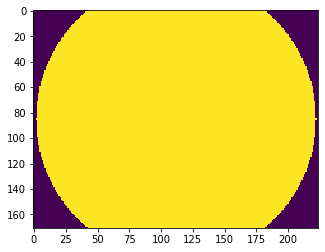

In [12]:
mask = np.zeros((171,224), np.uint8)
cv2.circle(mask, (mask.shape[1]//2,mask.shape[0]//2), 110, 255 , -1)
plt.imshow(mask.astype(np.uint8)*255)
plt.show()

In [13]:
# !jupyter nbconvert --to script _HMD_Light_main.ipynb

In [14]:
                    
#             elif Project_Type == 2: #Project_on_Floor go forward
#                 """project on Floor go forward"""
#                 #find plane by RANSAC
#                 surface_plane, depthImg, plane_mask, best_sampts, best_inlinernum = \
#                 _RANSAC.RANSAM(points3D, Confidence_img, ransac_iteration = 50, inliner_threshold = 0.02, last_inliner_num = last_inliner_num)#1cm  0.003
#                 last_inliner_num = best_inlinernum
                
#                 #turn bool img to uint8
#                 plane_img = plane_mask.astype(np.uint8)*255 
                
#                 #find large 四邊形 on the mask of plane, and find the center of it
#                 find_quad_success, find_quad_img, approx, cx, cy = _Find_quad.find_quadrilateral(plane_img)
                
#                 if find_quad_success:
#                     # Get the quad_mask
#                     mask_success, quad_mask = _Find_quad.find_quad_mask(approx, plane_img.shape)
#                     if mask_success:
#                         feet_img, height_mask_region, ellipse_list, feet_list = \
#                             _feet_detection.feet_list_detection(depthImg, quad_mask, height = 0.03, feet_height = 0.12) #5-8cm 
            
#                         find_feet_top_success, centerX, centerY, minX, minY, maxX, maxY, feet_img = \
#                             _feet_detection.find_center_and_vector_by_top(feet_list, feet_img, plane_mask)
                        
# #                         if(find_feet_top_success):
# #                             feet_img, px, py = \
# #                                 _feet_detection.find_plane_center(centerX, centerY, minX, minY, maxX, maxY, feet_img, points3D, plane_size = 0.2)
            
#                         if(SendData and find_feet_top_success):
#                             _Tranform_Data.send_forward_vector(minX, minY, maxX, maxY, points3D)
                        
#                             feet_img, px, py = \
#                                 _feet_detection.find_plane_center(centerX, centerY, minX, minY, maxX, maxY, feet_img, points3D, plane_size = 0.2)
#                             _Tranform_Data.send_targetpos(px, py, points3D)
                            

                            
#                 #show image
# #                 painter.paint (item_z, 'Depth')
#                 painter.paint (grayvalue_img, 'grayvalue_img')
# #                 painter.paint (quad_mask.astype(np.uint8)*255 , 'quad_mask')
#                 painter.paint (feet_img, 'feet_img')
# #                 painter.paint (height_mask_region, 'height_mask_region')
                
                
#                 if(SendData):
#                     _Tranform_Data.send_plane_eq(surface_plane)
                    
               